In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')

from eda import *

In [3]:
two_four_fp = '../data/240p/'
three_six_fp = '../data/360p/'
four_eight_fp = '../data/480p/'
seven_two_fp = '../data/720p/'
ten_eight_fp = '../data/1080p/' 

In [4]:
mbit_rate = 1/125000

In [5]:
iman_two_four = pd.read_csv(two_four_fp + "imnemato-110-action-240p-20210202.csv")
iman_three_six = pd.read_csv(three_six_fp + "imnemato-110-action-360p-20210213.csv")
iman_four_eight = pd.read_csv(four_eight_fp + "imnemato-110-action-480p-20210202.csv")
iman_seven_two = pd.read_csv(seven_two_fp + "imnemato-110-action-720p-20210213.csv")
iman_ten_eight = pd.read_csv(ten_eight_fp + "imnemato-110-action-1080p-20210202.csv")[30:].reset_index(drop=True)

iman_two_four['resolution'] = '240p'
iman_four_eight['resolution'] = '480p'
iman_three_six['resolution'] = '360p'
iman_seven_two['resolution'] = '720p'
iman_ten_eight['resolution'] = '1080p'

iman_df = pd.concat((iman_two_four, iman_three_six, iman_four_eight, iman_seven_two, iman_ten_eight))

In [6]:
stdoan_two_four = pd.read_csv(two_four_fp + "stdoan-101-action-240p-20201127.csv")
stdoan_three_six = pd.read_csv(three_six_fp + "stdoan-101-action-360p-20201206.csv")
stdoan_four_eight = pd.read_csv(four_eight_fp + "stdoan-101-action-480p-20201127.csv")
stdoan_seven_two = pd.read_csv(seven_two_fp + "stdoan-101-action-720p-20201127.csv")
stdoan_ten_eight = pd.read_csv(ten_eight_fp + "stdoan-101-action-1080p-20201127.csv")

stdoan_two_four['resolution'] = '240p'
stdoan_four_eight['resolution'] = '480p'
stdoan_three_six['resolution'] = '360p'
stdoan_seven_two['resolution'] = '720p'
stdoan_ten_eight['resolution'] = '1080p'

stdoan_df = pd.concat((stdoan_two_four, stdoan_three_six, stdoan_four_eight, stdoan_seven_two, stdoan_ten_eight))

## Quick Summary Statistics

In our previous quarter, we observed that general aggregate statistics such as mean and standard deviation were fairly decent at differentiating video and no video. When we ran such statistics on different resolutions, we see that there is a general increase in data payload but resolutions that are fairly close (360p and 480p in this case) can have very similiar aggregate values.

However, the main thing to keep in mind about working with network traffic data is that we are mostly interested in the behavior over time. Aggregate functions over a whole dataset hide small nuances between each resolution

In [ ]:
stdoan_two_four[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe().loc[['mean', 'std']]

In [ ]:
stdoan_three_six[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe().loc[['mean', 'std']]

In [ ]:
stdoan_four_eight[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe().loc[['mean', 'std']]

In [ ]:
stdoan_seven_two[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe().loc[['mean', 'std']]

In [ ]:
stdoan_ten_eight[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe().loc[['mean', 'std']]

## Comparing Byte Stream

### Download (Raw Second Analysis)
Visualizations help a lot when trying to differentiante the resolutions. It gives us a rough idea of intervals between large data payloads and how much data is being transferred at a time. We are given the option of looking at both download and upload. However, we observed that data behavior between the two streams is fairly similar (upload has a smaller magnitude).

Our initial idea was to plot just the download stream of bytes. In our initial plotting of the data, we observed that data payload increases as resolutions increases. More interestingly, the frequency of these large data transfers also increases. For this particular user, it seems that the data transfer speed caps at around 10 Mbps even though their bandwidth is capable of supporting more than 4x that amount (e.g. the beginning of their 1080p session shows a small period of 40+ Mbps data transfer). 



In [7]:
res_col = ["240p", "360p", "480p", "720p", "1080p"]
iman_lst = [iman_two_four, iman_three_six, iman_four_eight, iman_seven_two, iman_ten_eight]
stdoan_lst = [stdoan_two_four, stdoan_three_six, stdoan_four_eight, stdoan_seven_two, stdoan_ten_eight]

In [ ]:
subplot_byte_stream(iman_lst, stdoan_lst, res_col, '2->1Bytes', 360)

### Download (Rolling Windows Analysis)

Ultimately, we want to classify the resolution. Given the nature of our data, we wanted to apply and use methods that would capture behaviors over time. In the time domain, that meant using rolling windows to our advantage. Briefly, small windows captures finer details while larger windows capture more of the overall picture. We took 2 window sizes: 6 seconds and 60 seconds. 

With a 6 second window, there are some changes. The main one being that our data has now taken on a more square signal aspect. This is more observable in the higher resolution domain but it is still fairly present in the lower resolutions. Another change is that the "peaks" (now squares) are more uniform. This mainly impacted our lower resolution data. 

With a 60 second window, our lower resolution has become almost flat while our higher resolution data has become more square like. We hope that running FFT on the altered data (6s and 60s windows) will help distinguish the resolutions. Our hunch is that as the windows get bigger, FFT will still be able to locate strong signals in the higher resolution but struggle in the lower resolution.

In [ ]:
rolling_bytes_stream(stdoan_lst, res_col, 360, 6, 30, '500ms')

## Exploring Data Peaks

### Methodology & General Distribution
An interesting feature of our data are the "peaks" that occur. Each peak is a recorded observation of the local machine receiving a large amount of bytes from the VPN server. Large is a relative term when it comes to resolution. As observed in previous plots, we see that peaks of low resolution data is dwarfed by high resolution data. So when examining and analyzing our peaks, we decided to set peak threshold as relative to the data set. Setting a hard threshold could prove to be useful later on when constructing our model but for now, a relative threshold will give us better understanding.

We start with some basic boxplots to summarize and compare peaks across resolutions. Unsurprisingly, the median and interquartile range increases as our resolution increases. The point of interest is the "maximum" and the actual range of the IQR. Data of 480p resolution seems to have the widest range of data, sharing large portions of its range with its resolution neighbors. It is also interesting to see how similar the median values are between some of the resolutions.

In [ ]:
peaks_240 = preprocess_data_peaks(script_240_lst, '2->1Bytes')
peaks_360 = preprocess_data_peaks(script_360_lst, '2->1Bytes')
peaks_480 = preprocess_data_peaks(script_480_lst, '2->1Bytes')
peaks_720 = preprocess_data_peaks(script_720_lst, '2->1Bytes')
peaks_1080 = preprocess_data_peaks(script_1080_lst, '2->1Bytes')

In [ ]:
all_data = pd.concat((peaks_240, peaks_360, peaks_480, peaks_720, peaks_1080))

In [ ]:
stdoan_peaks = preprocess_data_peaks(stdoan_lst, '2->1Bytes')
iman_peaks = preprocess_data_peaks(iman_lst, '2->1Bytes')
subplot_peak_boxplot(stdoan_peaks, iman_peaks)

After viewing the general spread of the data through various statistics, we wanted to know the general distribution of the peaks across resolutions. Below are some quick histograms and the resultant density plot. Overall, the data tends to be right skewed, normal, or bimodal. However, the right skewness of some of the lower resolution data can be explained by the scale that we chose to plot on. By nature, lower resolution will use less bandwidth and thus lean more on the lower end of the Mbps scale.

In [ ]:
subplot_peak_kde_hist(stdoan_peaks, iman_peaks, res_col)

## Quick Spectral Analysis 

In previous classifiers, I found moderate success in sampling the data at 2Hz. However, this 2Hz sampling rate is not sufficient for some of our lower resolution/frequency data (480p and below). When trying to apply my original approach to the lower resolution/frequency data, the resultant spectrogram would be very noisy with no prominent peaks. In my experimentation, I found that decreasing the sampling rate to be within the sub 1Hz range produces well defined peaks for all of the resolutions. But rather than trying to characterize a data subset by its strongest frequency (and its corresponding PSD value), I found it more informative to bin the frequency range and then take the area under the curve of that bin. 

In [9]:
%%time
size = '2000ms'

iman_resample_lst = [convert_ms_df(df).resample(size, on='Time').sum() for df in iman_lst]
stdoan_resample_lst = [convert_ms_df(df).resample(size, on='Time').sum() for df in stdoan_lst]

Wall time: 10.9 s


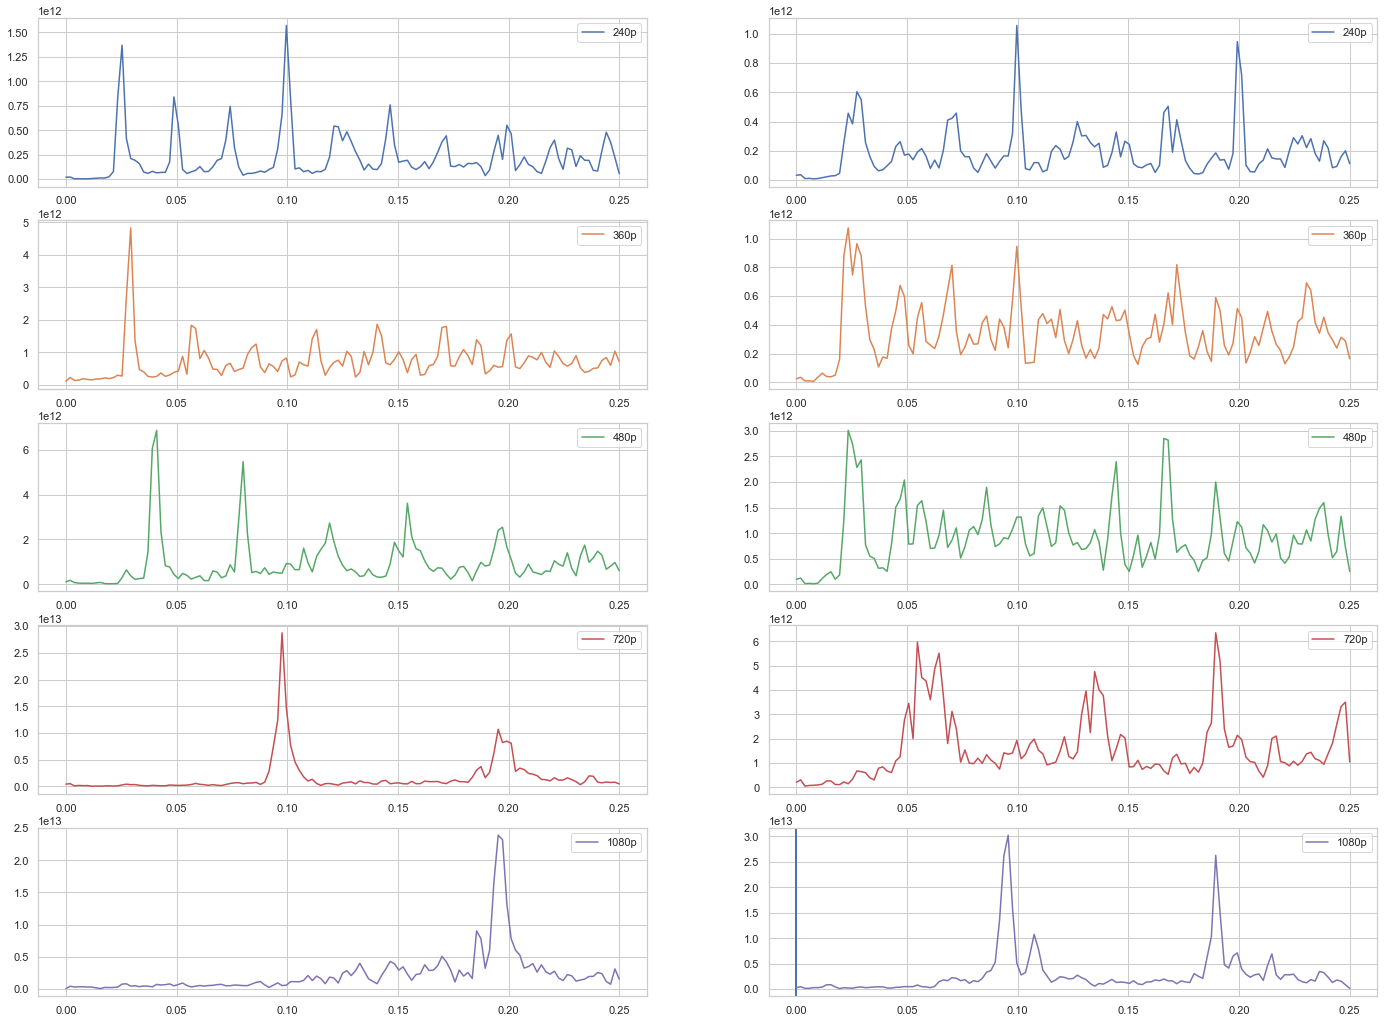

In [33]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(5, 2, figsize=(24, 18), sharex=False, sharey=False)

color_lst = sns.color_palette()

iman_resample_lst = [convert_ms_df(df).resample(size, on='Time').sum() for df in iman_lst]
stdoan_resample_lst = [convert_ms_df(df).resample(size, on='Time').sum() for df in stdoan_lst]

i = 0
for df in iman_resample_lst:
  f, Pxx = sp.signal.welch(df['pkt_size'], fs=.5)
  sns.lineplot(f, Pxx, ax=axes[i, 0], label=res_col[i], color=color_lst[i])
  i+=1

j = 0
for df in stdoan_resample_lst:
  f, Pxx = sp.signal.welch(df['pkt_size'], fs=.5)
  sns.lineplot(f, Pxx, ax=axes[j, 1], label=res_col[j], color=color_lst[j])
  j+=1

## Feature Engineering stuff

In [ ]:
def chunk_data(df, interval=120):
    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """
    df_list = []
    df['Time'] = df['Time'] - df['Time'].min()
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
        start = chunk * interval
        end = (chunk+1) * interval
        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        df_list.append(temp_df)
        
    return df_list

In [ ]:
two_four_script = os.listdir(two_four_fp)
three_six_script = os.listdir(three_six_fp)
four_eight_script = os.listdir(four_eight_fp)
seven_two_script = os.listdir(seven_two_fp)
ten_eight_script = os.listdir(ten_eight_fp)

In [ ]:
def add_resolution(fp, res):
  temp_df = pd.read_csv(fp)
  temp_df['resolution'] = res
  return temp_df

In [ ]:
script_240_lst = [add_resolution(two_four_fp + fp, '240p') for fp in two_four_script]
script_360_lst = [add_resolution(three_six_fp + fp, '360p') for fp in three_six_script]
script_480_lst = [add_resolution(four_eight_fp + fp, '480p') for fp in four_eight_script]
script_720_lst = [add_resolution(seven_two_fp + fp, '720p') for fp in seven_two_script]
script_1080_lst = [add_resolution(ten_eight_fp + fp, '1080p') for fp in ten_eight_script]


In [ ]:
chunk_240_lst = sum([chunk_data(df) for df in script_240_lst], [])
chunk_360_lst = sum([chunk_data(df) for df in script_360_lst], [])
chunk_480_lst = sum([chunk_data(df) for df in script_480_lst], [])
chunk_720_lst = sum([chunk_data(df) for df in script_720_lst], [])
chunk_1080_lst = sum([chunk_data(df) for df in script_1080_lst], [])

In [ ]:
test_rolling = chunk_480_lst[3][['2->1Bytes']].rolling(2).mean()

In [ ]:
idx = np.where(get_peak_loc(test_rolling, '2->1Bytes') == True)[0]

In [ ]:
len(chunk_240_lst)

In [ ]:
%%time
script_240_resample = [convert_ms_df(df).resample(size, on='Time').sum() for df in chunk_240_lst]
script_360_resample = [convert_ms_df(df).resample(size, on='Time').sum() for df in chunk_360_lst]
script_480_resample = [convert_ms_df(df).resample(size, on='Time').sum() for df in chunk_480_lst]
script_720_resample = [convert_ms_df(df).resample(size, on='Time').sum() for df in chunk_720_lst]
script_1080_resample = [convert_ms_df(df).resample(size, on='Time').sum() for df in chunk_1080_lst]

In [ ]:
# sns.set_style('whitegrid')
# fig, axes = plt.subplots(10, 1, figsize=(24, 24), sharex=False, sharey=False)

def power_density(resample_lst, bins):
  pxx_lst = []
  for df in resample_lst:
    f_temp, Pxx_temp = sp.signal.welch(df['pkt_size'], fs=.5) 
    freq = np.linspace(0, np.max(f_temp) + .01, num=bins) - .001
    total = np.trapz(y=Pxx_temp, x=f_temp)
    temp_lst = []
    for i in np.arange(len(freq) - 1):
      
      f_lower = np.where(f_temp >= freq[i])
      f_upper = np.where(f_temp < freq[i+1] )
      selected_range = np.intersect1d(f_lower, f_upper)
      
      pxx_den = np.trapz(y=Pxx_temp[selected_range], x=f_temp[selected_range]) / total
      
      temp_lst.append(pxx_den)
      
    pxx_lst.append(temp_lst)  
  return pxx_lst

In [ ]:
bin_size = 4

pxx_240 = power_density(script_240_resample, bin_size)
pxx_360 = power_density(script_360_resample, bin_size)
pxx_480 = power_density(script_480_resample, bin_size)
pxx_720 = power_density(script_720_resample, bin_size)
pxx_1080 = power_density(script_1080_resample, bin_size)


In [ ]:
np.mean(pxx_240, axis=0)

In [ ]:
np.mean(pxx_360, axis=0)

In [ ]:
np.mean(pxx_480, axis=0)

In [ ]:
np.mean(pxx_720, axis=0)

In [ ]:
np.mean(pxx_1080, axis=0)

In [ ]:
test = stdoan_lst[0]